# An example of a difficult EDA

## Dr Jose M. Albornoz
### October 18th, 2022 


This notebook shows an example of a binary classification dataset that resulted refractory to the exploratory data analysis - in other words, the EDA did not show any features with predictive power; in spite of this, a predictive model was built with an AUC = 0.8566. 

This is an example of a cleverly doctored dataset: all the features are numerical, and all of them contain apparent outliers.

# 0.- Imports and settings

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import cm
style.use('fivethirtyeight')
%matplotlib inline

# set figure size
FIG_SIZE = (6,4)
plt.rcParams["figure.figsize"] = FIG_SIZE

import seaborn as sns

import random
from itertools import combinations
from statistics import mean

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier


# maximum number of dataframe rows and columns displayed
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)

RANDOM_STATE = 801
pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings("ignore")

# 1.- Load dataset 

In [2]:
data0 = pd.read_csv('ml_test/public_train.csv')

In [3]:
data0.shape

(100000, 11)

The dataset has 100k rows rows and 11 columns.

In [4]:
# view first few rows of the data
data0.head()

,class_col,variable_0,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_9
0,0,1.616623,-0.909091,3.0,-0.041629,0.284188,0.166667,0.0,0.0,1.0,2.0
1,0,-0.029310,1.500000,0.0,0.551353,-0.515812,0.166667,0.0,-0.5,0.0,0.0
2,0,1.598362,0.227273,0.0,-0.280171,-0.385897,-1.166667,0.0,-0.5,0.0,0.0
3,0,0.355677,0.954545,0.0,-0.101158,0.158718,-0.333333,0.0,0.0,0.0,0.0
4,0,-0.291358,0.590909,0.0,-0.299727,0.696838,0.000000,0.0,0.5,0.0,0.0


## 1.1.- Feature types

In [5]:
data0.dtypes

class_col       int64
variable_0    float64
variable_1    float64
variable_2    float64
variable_3    float64
variable_4    float64
variable_5    float64
variable_6    float64
variable_7    float64
variable_8    float64
variable_9    float64
dtype: object

All features are numeric. 

## 1.2.- Unique values per feature

In [6]:
for col in data0.columns:
    print(col, ': ', data0[col].unique())

class_col :  [0 1]
variable_0 :  [ 1.61662315 -0.02931037  1.59836175 ...  0.12700466  0.01279284
  0.2971423 ]
variable_1 :  [-0.90909091  1.5         0.22727273  0.95454545  0.59090909  0.
  0.04545455  0.54545455  1.31818182 -0.31818182 -0.5        -0.81818182
  0.31818182 -0.68181818  0.18181818 -0.04545455  0.09090909  0.45454545
  0.72727273 -0.13636364  0.40909091 -1.22727273 -0.36363636  1.
  1.27272727 -0.63636364 -0.09090909  0.36363636 -0.59090909  0.63636364
  0.27272727 -1.36363636  1.04545455 -1.09090909  0.5        -1.27272727
 -0.72727273 -0.54545455  1.63636364  0.13636364  0.90909091  1.22727273
 -0.22727273  0.77272727  1.09090909  1.68181818 -1.18181818 -0.77272727
  1.40909091  0.86363636 -0.86363636 -0.27272727 -0.45454545 -1.04545455
 -0.40909091  1.54545455  1.45454545 -1.          1.13636364  1.18181818
  0.68181818 -1.13636364 -0.18181818  1.36363636 -0.95454545  0.81818182
  1.72727273 -1.40909091  1.59090909  1.95454545  1.77272727  1.86363636
 -1.31818182  

In [7]:
data0.nunique()

class_col         2
variable_0    84517
variable_1       85
variable_2       16
variable_3    79055
variable_4    11928
variable_5       55
variable_6       19
variable_7       27
variable_8       11
variable_9       12
dtype: int64

## 1.3.- Missing values

In [8]:
data0.isnull().sum()

class_col     0
variable_0    0
variable_1    0
variable_2    0
variable_3    0
variable_4    0
variable_5    0
variable_6    0
variable_7    0
variable_8    0
variable_9    0
dtype: int64

There are no missing values in the dataset.

# 2.- Exploratory data analysis: Part A

Let's begin by spliting the dataset into the target and the features we will use for prediction:

In [9]:
target_name = "class_col"
features, target = data0.drop(columns=target_name), data0[target_name]

## 2.1.- Target analysis

Let's examine the distribution of values for the prediction target:

In [10]:
target.value_counts()

0    93349
1     6651
Name: class_col, dtype: int64

In [11]:
target.value_counts()*100/data0.shape[0]

0    93.349
1     6.651
Name: class_col, dtype: float64

Text(0.5, 0, 'class_col')

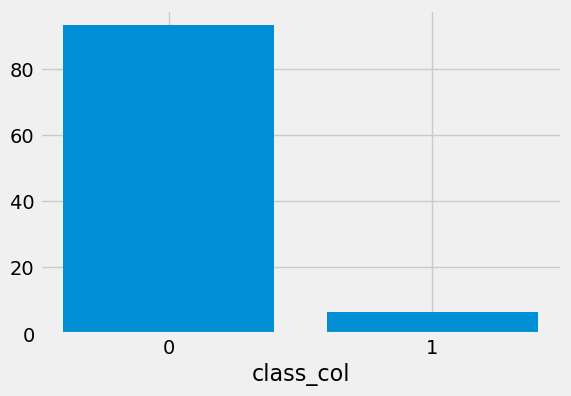

In [12]:
plt.bar(['0', '1'], target.value_counts()*100/features.shape[0])
plt.xlabel('class_col', fontsize=16)

We have a strongly imbalanced dataset, with 6.65% corresponding to the positive class. Roughly a 1:14 proportion between positive and negative values is observed.

## 2.2.- Feature analysis

We will examine in detail the features that will be used to train a predictive model. Several features contain what seem to be outliers;; we will therefore take a closer look at those features.

<font size="4">**variable_0**:</font>

In [13]:
features['variable_0'].describe()

count    100000.000000
mean         12.107321
std         528.035137
min          -0.291358
25%          -0.234323
50%           0.001486
75%           0.759917
max       95823.652218
Name: variable_0, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe3d89b1730>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe3d89b12e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe3d89b1490>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe3d89b1d30>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe3d89b1fd0>],
 'means': []}

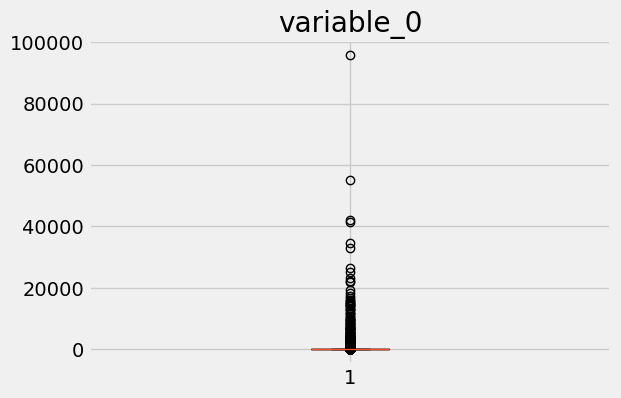

In [14]:
fig1, ax1 = plt.subplots()
ax1.set_title('variable_0')
ax1.boxplot(features['variable_0'])


<font size="4">**variable_1**:</font>

In [15]:
features['variable_1'].describe()

count    100000.000000
mean          0.013599
std           0.671062
min          -2.363636
25%          -0.500000
50%           0.000000
75%           0.500000
max           2.590909
Name: variable_1, dtype: float64

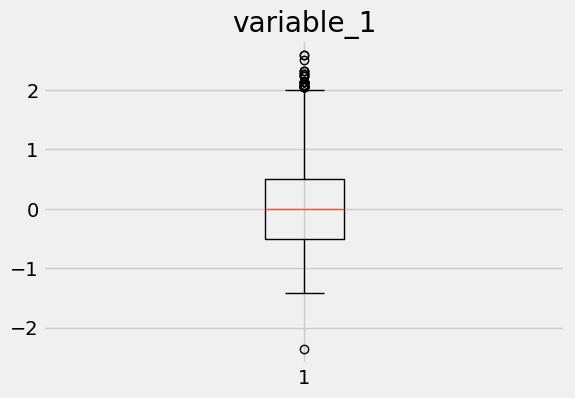

In [16]:
fig1, ax1 = plt.subplots()
ax1.set_title('variable_1')
ax1.boxplot(features['variable_1']);


<font size="4">**variable_2**:</font>

In [17]:
features['variable_2'].describe()

count    100000.000000
mean          0.433970
std           4.324017
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: variable_2, dtype: float64

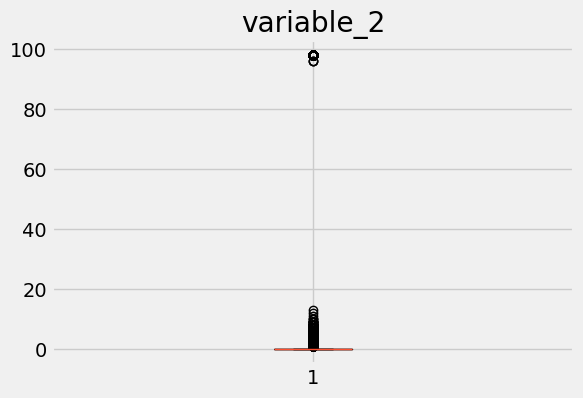

In [18]:
fig1, ax1 = plt.subplots()
ax1.set_title('variable_2')
ax1.boxplot(features['variable_2']);


<font size="4">**variable_3**:</font>

In [19]:
features['variable_3'].describe()

count    100000.000000
mean        500.308938
std        2181.510949
min          -0.528734
25%          -0.275459
50%           0.000119
75%           0.721373
max      318121.775385
Name: variable_3, dtype: float64

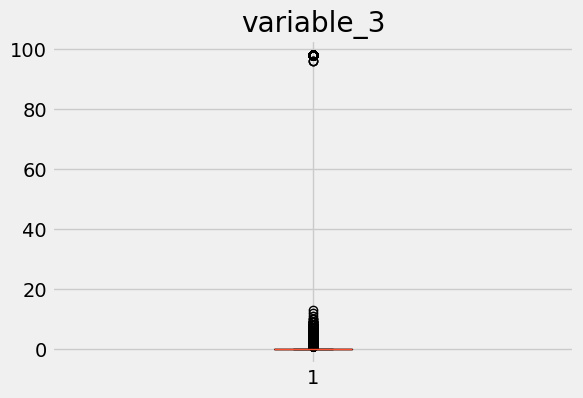

In [20]:
fig1, ax1 = plt.subplots()
ax1.set_title('variable_3')
ax1.boxplot(features['variable_2']);


<font size="4">**variable_4**:</font>

In [21]:
features['variable_4'].describe()

count    100000.000000
mean          0.167428
std           1.843019
min          -0.744872
25%          -0.471368
50%           0.004530
75%           0.520085
max         305.932051
Name: variable_4, dtype: float64

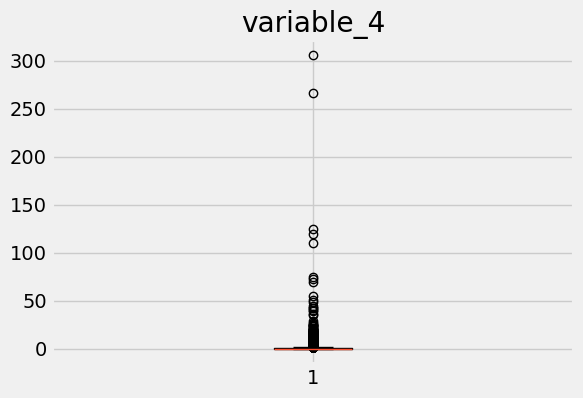

In [22]:
fig1, ax1 = plt.subplots()
ax1.set_title('variable_4')
ax1.boxplot(features['variable_4']);


<font size="4">**variable_5**:</font>

In [23]:
features['variable_5'].describe()

count    100000.000000
mean          0.079292
std           0.860352
min          -1.333333
25%          -0.500000
50%           0.000000
75%           0.500000
max           8.333333
Name: variable_5, dtype: float64

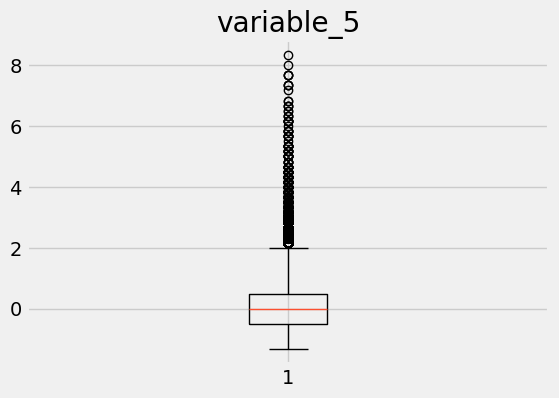

In [24]:
fig1, ax1 = plt.subplots()
ax1.set_title('variable_5')
ax1.boxplot(features['variable_5']);


<font size="4">**variable_6**:</font>

In [25]:
features['variable_6'].describe()

count    100000.000000
mean          0.277340
std           4.301489
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: variable_6, dtype: float64

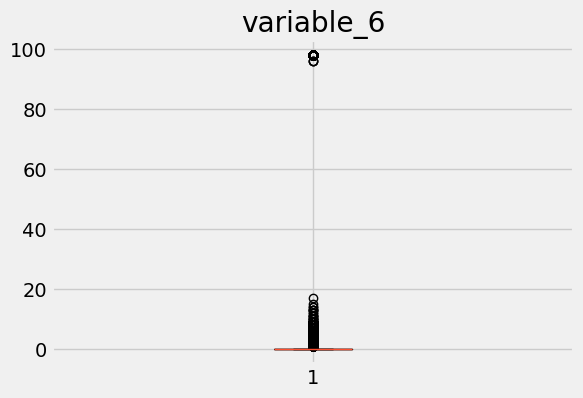

In [26]:
fig1, ax1 = plt.subplots()
ax1.set_title('variable_6')
ax1.boxplot(features['variable_6']);


<font size="4">**variable_7**:</font>

In [27]:
features['variable_7'].describe()

count    100000.000000
mean          0.010735
std           0.571463
min          -0.500000
25%          -0.500000
50%           0.000000
75%           0.500000
max          26.500000
Name: variable_7, dtype: float64

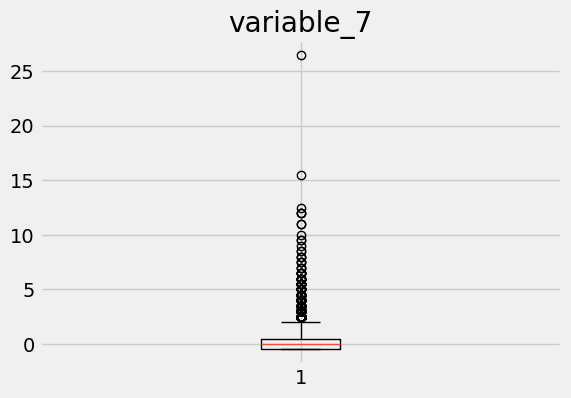

In [28]:
fig1, ax1 = plt.subplots()
ax1.set_title('variable_7')
ax1.boxplot(features['variable_7']);


<font size="4">**variable_8**:</font>

In [29]:
features['variable_8'].describe()

count    100000.000000
mean          0.251830
std           4.287297
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: variable_8, dtype: float64

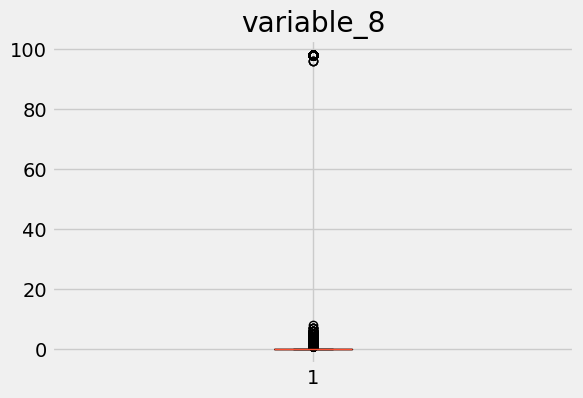

In [30]:
fig1, ax1 = plt.subplots()
ax1.set_title('variable_8')
ax1.boxplot(features['variable_8']);


<font size="4">**variable_9**:</font>

In [31]:
features['variable_9'].describe()

count    100000.000000
mean          0.740360
std           1.108458
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: variable_9, dtype: float64

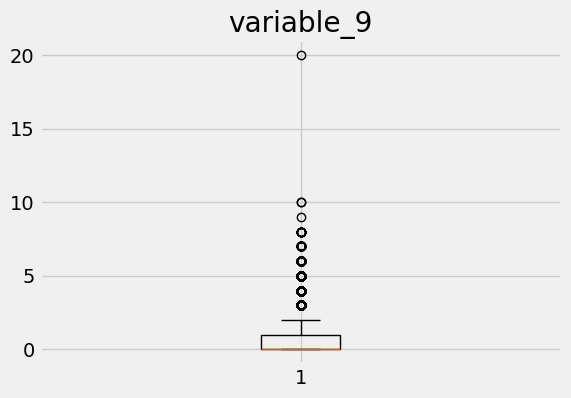

In [32]:
fig1, ax1 = plt.subplots()
ax1.set_title('variable_9')
ax1.boxplot(features['variable_9']);

# 3.- Exploratory data analysis: Part B

In this stage of the analysis we will contrast the values of the features for the two outcomes to be predicted; this will help identify features providing separation between classes.

We will divide the original dataset into two subsets: one that corresponds to target label $1$, and another that corresponds to target label $2$.

In [33]:
positiveOutcome = data0[data0[target_name] == 1]
negativeOutcome = data0[data0[target_name] == 0]

Comparison between the two outcomes will be performed for the features by comparing 'box-and-whiskers' plots for the two cases of interest. 


<font size="4">**variable_0**:</font>

[Text(1, 0, '1'), Text(2, 0, '0')]

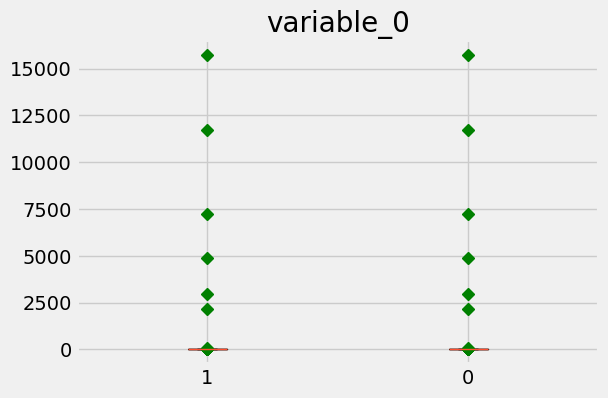

In [34]:
fig, ax = plt.subplots(figsize=FIG_SIZE)

plt.boxplot([positiveOutcome['variable_0'], positiveOutcome['variable_0']], 0, 'gD')

plt.title('variable_0', fontsize=20)

labels = ['1', '0']
ax.set_xticklabels(labels, fontsize=14)


<font size="4">**variable_1**:</font>

[Text(1, 0, '1'), Text(2, 0, '0')]

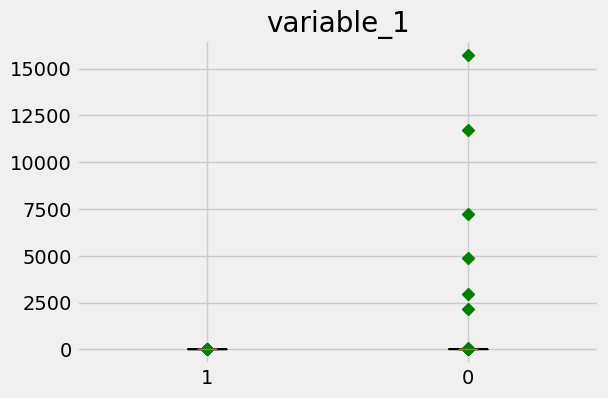

In [35]:
fig, ax = plt.subplots(figsize=FIG_SIZE)

plt.boxplot([positiveOutcome['variable_1'], positiveOutcome['variable_0']], 1, 'gD')

plt.title('variable_1', fontsize=20)

labels = ['1', '0']
ax.set_xticklabels(labels, fontsize=14)


<font size="4">**variable_2**:</font>

[Text(1, 0, '1'), Text(2, 0, '0')]

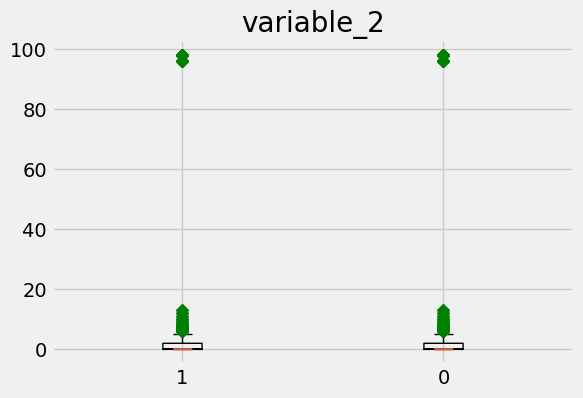

In [36]:
fig, ax = plt.subplots(figsize=FIG_SIZE)

plt.boxplot([positiveOutcome['variable_2'], positiveOutcome['variable_2']], 1, 'gD')

plt.title('variable_2', fontsize=20)

labels = ['1', '0']
ax.set_xticklabels(labels, fontsize=14)

No significant difference between the two cases of interest for this feature.


<font size="4">**variable_3**:</font>

[Text(1, 0, '1'), Text(2, 0, '0')]

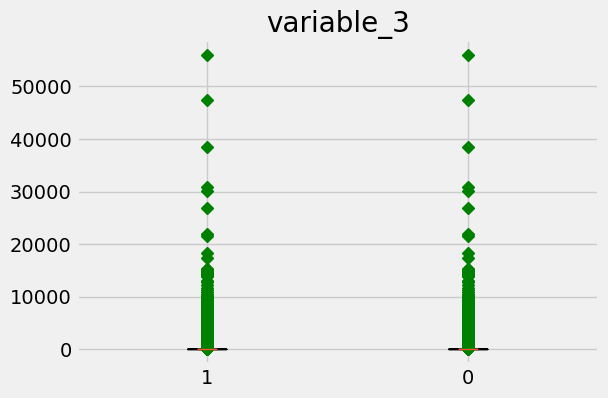

In [37]:
fig, ax = plt.subplots(figsize=FIG_SIZE)

plt.boxplot([positiveOutcome['variable_3'], positiveOutcome['variable_3']], 1, 'gD')

plt.title('variable_3', fontsize=20)

labels = ['1', '0']
ax.set_xticklabels(labels, fontsize=14)

No significant difference between the two cases of interest for this feature.


<font size="4">**variable_4**:</font>

[Text(1, 0, '1'), Text(2, 0, '0')]

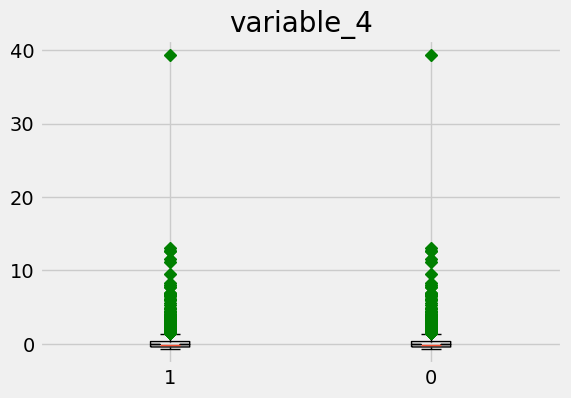

In [38]:
fig, ax = plt.subplots(figsize=FIG_SIZE)

plt.boxplot([positiveOutcome['variable_4'], positiveOutcome['variable_4']], 1, 'gD')

plt.title('variable_4', fontsize=20)

labels = ['1', '0']
ax.set_xticklabels(labels, fontsize=14)


<font size="4">**variable_5**:</font>

[Text(1, 0, '1'), Text(2, 0, '0')]

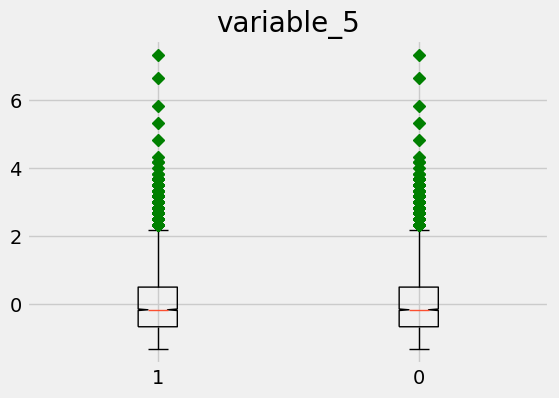

In [39]:
fig, ax = plt.subplots(figsize=FIG_SIZE)

plt.boxplot([positiveOutcome['variable_5'], positiveOutcome['variable_5']], 1, 'gD')

plt.title('variable_5', fontsize=20)

labels = ['1', '0']
ax.set_xticklabels(labels, fontsize=14)

<font size="4">**variable_6**:</font>

[Text(1, 0, '1'), Text(2, 0, '0')]

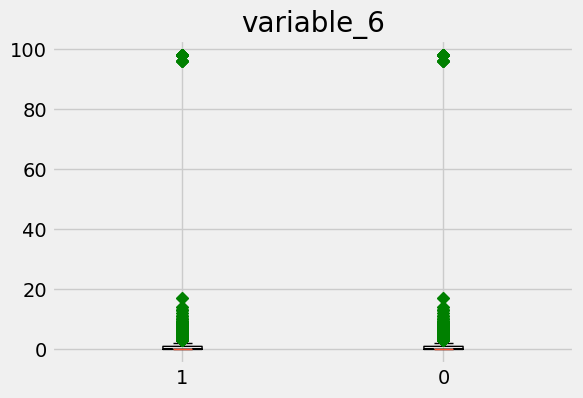

In [40]:
fig, ax = plt.subplots(figsize=FIG_SIZE)

plt.boxplot([positiveOutcome['variable_6'], positiveOutcome['variable_6']], 1, 'gD')

plt.title('variable_6', fontsize=20)

labels = ['1', '0']
ax.set_xticklabels(labels, fontsize=14)

<font size="4">**variable_7**:</font>

[Text(1, 0, '1'), Text(2, 0, '0')]

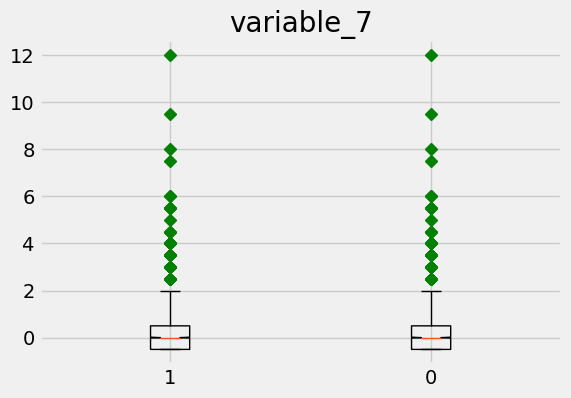

In [41]:
fig, ax = plt.subplots(figsize=FIG_SIZE)

plt.boxplot([positiveOutcome['variable_7'], positiveOutcome['variable_7']], 1, 'gD')

plt.title('variable_7', fontsize=20)

labels = ['1', '0']
ax.set_xticklabels(labels, fontsize=14)

<font size="4">**variable_8**:</font>

[Text(1, 0, '1'), Text(2, 0, '0')]

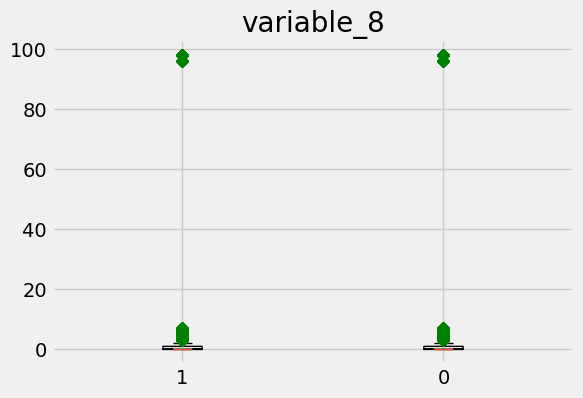

In [42]:
fig, ax = plt.subplots(figsize=FIG_SIZE)

plt.boxplot([positiveOutcome['variable_8'], positiveOutcome['variable_8']], 1, 'gD')

plt.title('variable_8', fontsize=20)

labels = ['1', '0']
ax.set_xticklabels(labels, fontsize=14)

<font size="4">**variable_9**:</font>

[Text(1, 0, '1'), Text(2, 0, '0')]

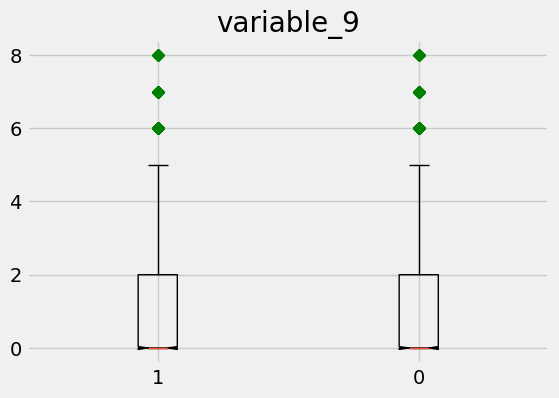

In [43]:
fig, ax = plt.subplots(figsize=FIG_SIZE)

plt.boxplot([positiveOutcome['variable_9'], positiveOutcome['variable_9']], 1, 'gD')

plt.title('variable_9', fontsize=20)

labels = ['1', '0']
ax.set_xticklabels(labels, fontsize=14)

The exploratory data analysis shows apparent outliers that make if difficult to identify features providing good predictive power; funnily enough, the outliers seem to be the same for the two outcomes of interest. Not having domain expertise about the process that generates this dataset, a) we will use the features as they are and b) we will select modeling approaches that are not sensitive to outliers.

# 4.- Feature engineering: search for differences

We will create a function that takes numeric features and searches for pairs of differences that are likely to improve the accuracy of tree-based models. It starts with a baseline model of a single decision tree fit to the input dataset’s numeric features. It then computes a difference between every pair of numeric features and loops through those differences, fitting a decision tree to the numeric features + the difference feature. If the difference feature improves the test-set accuracy of the model, that difference is kept.

In [44]:
def search_differences(df, target):
    
    feats, tgt = df.drop(columns=target), df[target]
    
    # train base decision tree classifier
    from sklearn.tree import DecisionTreeClassifier
    clf = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)
           
    # computes base AUC:
    from sklearn.model_selection import cross_validate, StratifiedKFold
    
    # generate stratified folds
    cv = StratifiedKFold(n_splits=5)
    cv_base = cross_validate(clf, feats, tgt, cv=cv, scoring='roc_auc', n_jobs=2)
    AUC_base = cv_base['test_score'].mean()
    
    # output dataframe 
    df_out = df.copy()   
    
    # generates pairs that correspond to all combinations of features 
    col_nums = [k for k in range(0, feats.shape[1])]
    pairs = list(combinations(col_nums, 2))
    
    # verifies if a particular difference of features improves AUC
    for k in range(len(pairs)):
        
        feats_tmp = feats.copy()
       
        # adds feature difference to input features
        feat_1, feat_2 = pairs[k][0], pairs[k][1]
        diff = feats_tmp.iloc[:, feat_1] - feats.iloc[:, feat_2]
        feats_tmp[f'diff_{pairs[k][0]}_{pairs[k][1]}'] = diff
             
        # computes AUC:
        cv = StratifiedKFold(n_splits=5)
        cv_tmp = cross_validate(clf, feats_tmp, tgt, cv=cv, scoring='roc_auc', n_jobs=2)
        AUC_tmp = cv_tmp['test_score'].mean()
                
        # verifies if AUC is improved by feature difference
        if (AUC_tmp > AUC_base):
            df_out[f'diff_{feat_1}_{feat_2}'] = diff
              
        return df_out

In [45]:
data_aug = search_differences(data0, target_name)

Examination of the augmented features shows there is only one difference that improvers predictive power.

# 5.- Predictive model v0

We will now explore two machine learning models using the augmented feature set generated in the previous step: **Xgboost** (as it is pretty much the gold standard for classification tasks) and the **balanced random forest classifier** from `imbalanced-learn`. Being tree-based models they a) do not require scaling of numerical features and b) are robust to outliers. We also need to take into accoun that we have a strongly imbalanced datsaset.

In [46]:
# split augmented data into features and target
features_aug, target = data_aug.drop(columns=target_name), data_aug[target_name]

In [47]:
# split into training & testing set
data_train, data_test, target_train, target_test = \
            train_test_split(features_aug, data_aug[target_name], stratify=target, random_state=RANDOM_STATE)

## 5.1.- Baseline models

Let's assess the performance of two baseline models first:

In [48]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)

#### Xgboost baseline model:

We will account for the strong target imbalance by scaling errors made by the model during training on the minority class using the `scale_pos_weight` hyperparameter. A sensible default value to set for `scale_pos_weight` is the inverse of the class distribution; in this dataset we have a 1:14 imbalance.

In [49]:
# XGBOOST BASELINE MODEL
model_baseline_xgb = XGBClassifier(random_state=RANDOM_STATE, scale_pos_weight=14)

In [50]:
# evaluate model
scores = cross_val_score(model_baseline_xgb, data_train, target_train, scoring='roc_auc', cv=cv, n_jobs=-1)

In [51]:
# summarize performance, xgboost model
print('Mean ROC AUC XGBOOST: %.5f' % mean(scores))

Mean ROC AUC XGBOOST: 0.84245


#### Balanced random forest baseline model:

In [52]:
# BALANCED RANDOM FOREST BASELINE MODEL
model_baseline_rf = BalancedRandomForestClassifier(random_state=RANDOM_STATE)

In [53]:
# evaluate model
scores = cross_val_score(model_baseline_rf, data_train, target_train, scoring='roc_auc', cv=cv, n_jobs=-1)

In [54]:
# summarize performance, balanced random forestt
print('Mean ROC AUC Random Forest: %.5f' % mean(scores))

Mean ROC AUC Random Forest: 0.85845


The balanced random forest classifier seem to perform better right out of the box.

## 5.1.- Xgboost

We will tune an Xgboost model using a nested cross-validation approach:

In [55]:
# XGBOOST MODEL
model_xgb = XGBClassifier(random_state=RANDOM_STATE, scale_pos_weight=14)

In [57]:
# xgboost hyperparameter grid
param_grid = {
    'learning_rate': ([0.01, 0.05, 0.1]),
    'n_estimators': ([100, 125]),    
    'colsample_bytree': ([0.7, 0.8]),
    'subsample': ([0.7, 0.8]),
    'max_depth': ([1, 2])
}

cv1 = StratifiedKFold(n_splits=5)
model_grid_search_xgb = GridSearchCV(model_xgb, param_grid=param_grid, n_jobs=2, cv=cv1)

In [58]:
cv2 = StratifiedKFold(n_splits=10)

cv_results = cross_validate(model_grid_search_xgb, data_train.values, target_train.values, cv=cv2, 
                            scoring='roc_auc', n_jobs=2, 
                            return_train_score=True, error_score="raise", return_estimator=True)

In [59]:
cv_results_DF = pd.DataFrame(cv_results)
cv_results_DF.head(10)

,fit_time,score_time,estimator,test_score,train_score
0,352.786574,0.014406,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.875497,0.859655
1,352.607666,0.022565,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.861471,0.860997
2,290.081331,0.011718,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.851485,0.862103
3,290.325204,0.014593,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.848164,0.862046
4,234.331463,0.010704,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.857842,0.861617
5,234.310249,0.009938,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.871462,0.859727
6,238.008843,0.009506,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.833841,0.864182
7,238.248472,0.012891,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.868028,0.860279
8,235.366488,0.013194,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.850868,0.861896
9,235.340775,0.006049,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.868111,0.860440


The above results look quite good: training and testing scores are close to each other - no overfitting.

In [60]:
print(f"The average training AUC is "
      f"{cv_results['train_score'].mean():.3f} +/- " \
      f"{cv_results['train_score'].std():.3f}")

The average training AUC is 0.861 +/- 0.001


In [61]:
print(f"The average testing AUC is "
      f"{cv_results['test_score'].mean():.3f} +/- " \
      f"{cv_results['test_score'].std():.3f}")

The average testing AUC is 0.859 +/- 0.012


Very little standard deviation across folds - nice!

We will select the hyperparameters for which the maximum test score was attained in the outer CV loop:

In [62]:
max_test_score_row = cv_results_DF.loc[cv_results_DF['test_score'].idxmax()]

In [63]:
print(f"The maximum test score was "
      f"{max_test_score_row['test_score']:.3f}")

The maximum test score was 0.875


In [64]:
max_test_score_row['estimator'].best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 1,
 'n_estimators': 125,
 'subsample': 0.8}

In [65]:
best_xgb_model = max_test_score_row['estimator']

We now re-train the best Xgboost model with all training data.

In [66]:
best_xgb_model.fit(data_train, target_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interacti...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=801, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=2,
             param_grid={'colsample_bytree': [0.7, 0.8],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [1, 2], 'n_estimators': [100, 125],
                         'subsample': [0.7, 0.8]})

### 5.1.1.- Xgboost performance on test set

In [68]:
# evaluate tuned model
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)

scores_xgb = cross_val_score(best_xgb_model, data_test, target_test, scoring='roc_auc', cv=cv, n_jobs=-1)

In [69]:
print('Final ROC AUC Xgboost: %.5f' % mean(scores_xgb))

Final ROC AUC Xgboost: 0.85664


This performance is better than the one attained by the Xgboost baseline model.

#### AUC plot:

In [70]:
probs_xgb = best_xgb_model.predict_proba(data_test)[:, 1]

In [71]:
fpr, tpr, threshold = roc_curve(target_test, probs_xgb)
roc_auc = auc(fpr, tpr)

Text(0.5, 0, 'False Positive Rate')

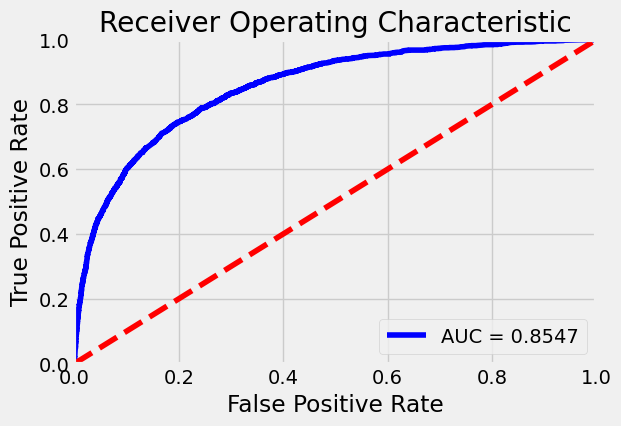

In [72]:
#create ROC curve
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## 5.2.- Balanced random forest classifier

In [73]:
model_rf = BalancedRandomForestClassifier(random_state=RANDOM_STATE)

In [74]:
# balanced rf hyperparameter grid
param_grid = {
    'criterion': (['entropy', 'gini']),
    'n_estimators': ([25, 35, 45]),
    'max_depth': ([3, 4, 5])    
}

cv1 = StratifiedKFold(n_splits=5)
model_grid_search_rf = GridSearchCV(model_rf, param_grid=param_grid, n_jobs=2, cv=cv1)

In [75]:
cv2 = StratifiedKFold(n_splits=10)

cv_results = cross_validate(model_grid_search_rf, data_train.values, target_train.values, cv=cv2, 
                            scoring='roc_auc', n_jobs=2, 
                            return_train_score=True, error_score="raise", return_estimator=True)

In [76]:
cv_results_DF = pd.DataFrame(cv_results)
cv_results_DF.head(10)

,fit_time,score_time,estimator,test_score,train_score
0,52.049836,0.025839,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.869498,0.852316
1,51.929134,0.017930,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.858265,0.858338
2,52.898909,0.018839,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.842342,0.859855
3,52.957632,0.017114,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.847226,0.858710
4,49.358695,0.015318,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.860047,0.861908
5,49.365548,0.014468,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.874267,0.860046
6,43.229781,0.013311,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.827391,0.860661
7,43.034510,0.013420,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.863049,0.856842
8,43.559737,0.013999,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.846993,0.857811
9,43.531788,0.013418,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.862415,0.856118


The above results look quite good: training and testing scores are close to each other - no overfitting.

In [77]:
print(f"The average training AUC is "
      f"{cv_results['train_score'].mean():.3f} +/- " \
      f"{cv_results['train_score'].std():.3f}")

The average training AUC is 0.858 +/- 0.003


In [78]:
print(f"The average testing AUC is "
      f"{cv_results['test_score'].mean():.3f} +/- " \
      f"{cv_results['test_score'].std():.3f}")

The average testing AUC is 0.855 +/- 0.013


Very little standard deviation across folds - nice!

We will select the hyperparameters for which the maximum test score was attained in the outer CV loop:

In [79]:
max_test_score_row = cv_results_DF.loc[cv_results_DF['test_score'].idxmax()]

In [80]:
print(f"The maximum test score was "
      f"{max_test_score_row['test_score']:.3f}")

The maximum test score was 0.874


In [81]:
max_test_score_row['estimator'].best_params_

{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 25}

In [82]:
best_brf_model = max_test_score_row['estimator']

We re-train the balanced random forest model with all training data:

In [83]:
best_brf_model.fit(data_train, target_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=BalancedRandomForestClassifier(random_state=801),
             n_jobs=2,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [3, 4, 5], 'n_estimators': [25, 35, 45]})

### 5.2.1.- Balanced random forest performance on test set

In [84]:
# evaluate tuned model
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)

scores = cross_val_score(best_brf_model, data_test, target_test, scoring='roc_auc', cv=cv, n_jobs=-1)

In [85]:
print('Final ROC AUC balanced random forest: %.5f' % mean(scores))

Final ROC AUC balanced random forest: 0.85003


The above result is not better than the one provided by the baseline model - this hints at the baseline model overfitting. Let's verify this:

In [86]:
model_baseline_rf = BalancedRandomForestClassifier(random_state=RANDOM_STATE)

In [87]:
cv2 = StratifiedKFold(n_splits=5)

cv_results = cross_validate(model_baseline_rf, data_train.values, target_train.values, cv=cv2, 
                            scoring='roc_auc', n_jobs=2, 
                            return_train_score=True, error_score="raise", return_estimator=True)

In [88]:
cv_results_DF = pd.DataFrame(cv_results)
cv_results_DF.head()

,fit_time,score_time,estimator,test_score,train_score
0,2.319954,0.225443,"(DecisionTreeClassifier(max_features='sqrt', r...",0.864022,0.982541
1,2.318527,0.223965,"(DecisionTreeClassifier(max_features='sqrt', r...",0.850753,0.983030
2,2.526648,0.236134,"(DecisionTreeClassifier(max_features='sqrt', r...",0.863655,0.982206
3,2.521882,0.219771,"(DecisionTreeClassifier(max_features='sqrt', r...",0.852945,0.981924
4,2.489859,0.225143,"(DecisionTreeClassifier(max_features='sqrt', r...",0.860518,0.981700


The baseline model is clearly ovefitting as seen in the above table!

AUC plot:

In [89]:
probs_rf = best_brf_model.predict_proba(data_test)[:, 1]

In [90]:
fpr, tpr, threshold = roc_curve(target_test, probs_rf)
roc_auc = auc(fpr, tpr)

Text(0.5, 0, 'False Positive Rate')

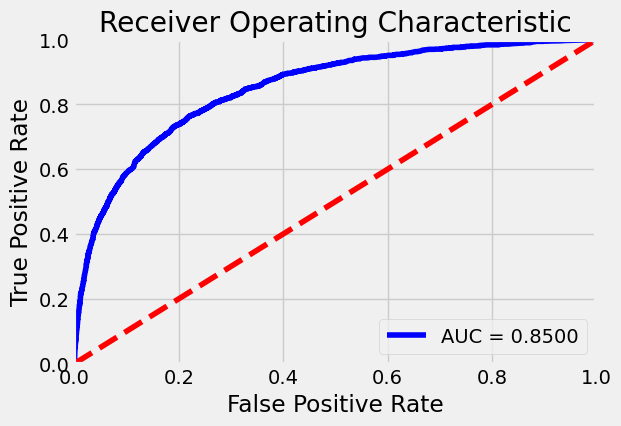

In [91]:
#create ROC curve
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## 6. - Predictions on test dataset

The best model was Xgboost; we will train it now on all available data.

In [92]:
best_model = best_xgb_model

In [93]:
best_model.fit(features_aug, target)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interacti...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=801, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=2,
             param_grid={'colsample_bytree': [0.7, 0.8],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [1, 2], 'n_estimators': [100, 125],
                         'subsample': [0.7, 0.8]})

In [94]:
data_test.head()

,variable_0,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_9,diff_0_1
11846,-0.211266,0.727273,0.0,-0.136839,0.673932,0.000000,0.0,1.0,0.0,1.0,-0.938539
13807,1.092766,-0.136364,0.0,-0.292090,0.349145,0.000000,0.0,-0.5,0.0,0.0,1.229129
70851,1.085089,-0.545455,1.0,-0.252856,-0.078205,-0.833333,1.0,-0.5,0.0,0.0,1.630544
34204,-0.123355,-0.409091,0.0,-0.111100,0.708120,-0.166667,0.0,0.5,0.0,2.0,0.285736
13481,-0.279863,0.227273,0.0,3458.890470,-0.744872,1.333333,0.0,0.0,0.0,1.0,-0.507136


In [95]:
data_test = pd.read_csv('ml_test/public_test.csv')

In [96]:
data_test['diff_0_1'] = data_test['variable_0'] - data_test['variable_1']

In [97]:
# probabilities for the positive class
probabilities = best_model.predict_proba(data_test)[:, 1]

In [98]:
pd.DataFrame(probabilities).to_csv("answers_classification_test.csv", index=False, header=False)